# Fine-tuning for Semantic Segmentation

This notebook is for the project of STATS 507 at University of Michigan.

In this notebook, I'm going to fine tune a pretrained vision model for semantic segmentation on a custom dataset in PyTorch. Next, a Lut (Look-up Table) filter will be applied on the image according to the segmentation result to preserve some "characteristic colors" such as colors of face and hair.

The report for this project can be found here.

### Model

For the project, I chose Apple’s MobileViT+DeepLabV3-small model as the initial model. MobileViT was pre-trained on PASCAL VOC with a resolution of 512$\times$512, and a DeepLabV3 head is integrated for semantic segmentation tasks. This combination provides a strong starting point for building an efficient and accurate model. This model has a relatively small parameter size of 6.4 million, which makes it easier and more suitable for deployment on mobile devices with limited computational power.

### Dataset

I used the Human Parsing Data dataset for fine-tune, which consists of 17,706 samples of fashionably dressed individuals. Each sample includes a 600$\times$400 original image and a corresponding mask image. The mask has 18 categories that segment the image pixels into regions such as background, hair, face, arms, and legs. This dataset is highly suitable for this project as it provides detailed labels of human skin and hair, which is crucial for the task of fine-tuning the model. However, the large number of images in the dataset made the training process slow without hardware acceleration. To overcome this, I utilized the Great Lakes ARC at the university, leveraging GPU acceleration to speed up the training process.

### Data Augmentation

# Code for Fine-Tuning

### Required Libraries

First, we need to install and load some libraries. One can just run the code and it will automatically install all the necessary libraires.

In [17]:
import importlib
import subprocess
import sys

# function to check and install the library
def check_and_install(package):
    try:
        importlib.import_module(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' is not installed. Installing now ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [18]:
# check the necessary libraries
required_packages = ["numpy", "torch", "evaluate", "datasets", "transformers", "albumentations", "pillow-lut"]
for package in required_packages:
    check_and_install(package)

# load the libraries
import numpy as np
import torch
import evaluate        # to evaluate the accuracy and performance
from torch import optim, nn        # core for neural network
from datasets import load_dataset        # to load the dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation        # to load the tokenizer and model
from torch.utils.data import DataLoader        # to shuffle and do batch processing
import albumentations as A        # to enhance the images

'numpy' is already installed.
'torch' is already installed.
'evaluate' is already installed.
'datasets' is already installed.
'transformers' is already installed.
'albumentations' is already installed.
'pillow-lut' is not installed. Installing now ...
Defaulting to user installation because normal site-packages is not writeable


### Loading the Dataset

Load the dataset: Human Parsing Data from

In [5]:
# load the dataset and split the train-test
dataset_identifier = "mattmdjaga/human_parsing_dataset"
ds = load_dataset(dataset_identifier, split="train[:100%]", num_proc=8)

Check the samples

In [7]:
ds

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

There are 17706 samples in this dataset.

The `ds` object is a `DatasetDict`, which contains one "train" split. The `features` tell us what each sample is consisted of:

- `image`: the actual image
- `mask`: segmentation mask

One example is shown down below.

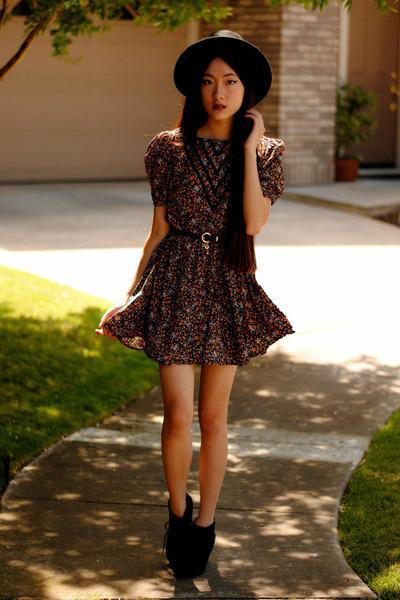

In [8]:
example = ds[5]
# example["image"].save("4.png")
example["image"]

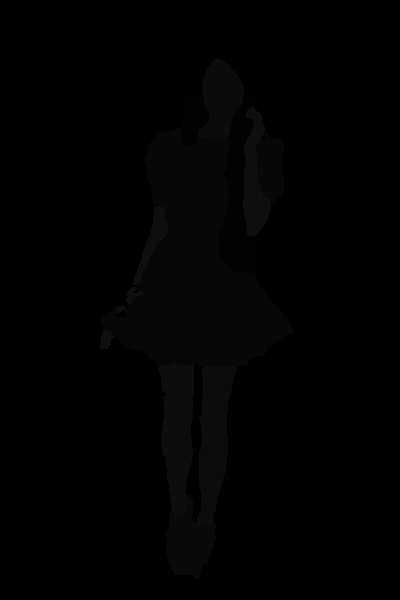

In [9]:
example["mask"]

Each of the pixels above in the mask image is associated to a particular category. Here I defined an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` is also useful when we

In [6]:
id2label = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf",
}

label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

Shuffle the dataset, and then split them into training and testing sets.

In [7]:
ds.shuffle(seed=1)

split_ratio = 0.006
split_size = int(len(ds) * split_ratio)
print(f"Testing data size: {split_size}")

ds_split = ds.train_test_split(test_size=split_ratio, seed=1)
train_ds = ds_split["train"]
test_ds = ds_split["test"]

Testing data size: 106


106 of the samples are split for testing.

### Preprocess the Data

Before we feed these images to the model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [8]:
# Image Transformations
img_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.OneOf(
            [
                A.Downscale(p=0.1, scale_min=0.4, scale_max=0.6),
                A.GaussNoise(p=0.2),
            ],
            p=0.1,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=0.2),
                A.ColorJitter(p=0.2),
                A.HueSaturationValue(p=0.2),
            ],
            p=0.1,
        ),
        A.OneOf([A.PixelDropout(p=0.2), A.RandomGravel(p=0.2)], p=0.15),
    ]
)

In [9]:
# Dataset Transformation Functions
def train_transforms(example_batch):
    trans = [
        img_transforms(image=np.array(x), mask=np.array(m))
        for x, m in zip(example_batch["image"], example_batch["mask"])
    ]
    images = [x["image"] for x in trans]
    labels = [x["mask"] for x in trans]
    inputs = tokenizer(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["mask"]]
    inputs = tokenizer(images, labels)
    return inputs


train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training.

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [10]:
# Metrics and Validation
metric = evaluate.load("mean_iou")


@torch.no_grad()
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    logits_tensor = logits.argmax(dim=1)

    pred_labels = logits_tensor

    mets = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=255,
        reduce_labels=False,
    )
    for key, value in mets.items():
        if type(value) is np.ndarray:
            mets[key] = value.tolist()

    return mets


@torch.no_grad()
def validation(model, val_loader):

    model.eval()
    val_losses = []
    all_labels = []
    all_logits = []

    for i, batch in enumerate(val_loader, 1):
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)

        outputs = model(inputs)
        logits_tensor = nn.functional.interpolate(
            outputs.logits,  # Detach to avoid saving gradients
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        loss = loss_func(logits_tensor, labels)
        val_losses.append(loss.item())

        # Storing logits and labels as CPU tensors to save GPU memory
        all_labels.append(labels.cpu())
        all_logits.append(logits_tensor.cpu())

    # Concatenate all logits and labels
    logits = torch.cat(all_logits, dim=0).to(config.device)
    labels = torch.cat(all_labels, dim=0).to(config.device)

    model.train()
    return logits, labels, val_losses

### Load the Model

In [11]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Configuration of the process

In [12]:
class TrainingConfig:
    batch_size: int = 8
    epochs: int = 8
    learning_rate: float = 1e-4
    background_weight: float = 1.0
    other_classes_weight: float = 3.0
    lr_decay_rate: float = 0.9998
    seed: int = 42
    model_name: str = "apple/deeplabv3-mobilevit-small"
    device = device


config = TrainingConfig()

In [13]:
# Model and Tokenizer Initialization
tokenizer = SegformerImageProcessor.from_pretrained(config.model_name)
tokenizer.do_center_crop = False

model = AutoModelForSemanticSegmentation.from_pretrained(
    config.model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
).to(config.device)

/home/sunjiaqi/.local/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'crop_size', 'do_center_crop', 'do_flip_channels', 'feature_extractor_type'
  return func(*args, **kwargs)
Some weights of MobileViTForSemanticSegmentation were not initialized from the model checkpoint at apple/deeplabv3-mobilevit-small and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([18, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([18]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define function to save the model

In [14]:
def save_model(model, tokenizer, name):
    model.save_pretrained(name)
    tokenizer.save_pretrained(name)

In [15]:
# DataLoader, Optimizer, and Scheduler
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
lambda1 = lambda step: config.lr_decay_rate**step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

weights = torch.tensor(
    [config.background_weight] + [config.other_classes_weight] * 17
).to(config.device)
loss_func = nn.CrossEntropyLoss(weight=weights)

### Train the Model

In [16]:
t_steps = 0
log_list = []
running_loss = []

for epoch in range(config.epochs):
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = batch["pixel_values"].to(config.device)
        labels = batch["labels"].to(config.device)
        outputs = model(inputs)
        # The models predicts small masks, so we need to upsample them to the correct size like in inference
        logits_tensor = nn.functional.interpolate(
            outputs.logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )
        loss = loss_func(logits_tensor, labels)
        running_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()


        if t_steps % 500 == 0:
            logs = {}

            last_lr = scheduler.get_last_lr()[0]

            logits_tensor, labels, val_losses = validation(model, val_loader)
            r_loss = sum(running_loss) / len(running_loss)
            val_loss = sum(val_losses) / len(val_losses)

            mets = compute_metrics((logits_tensor, labels))

            logs["training_loss"] = r_loss
            logs["val_loss"] = val_loss

            for key, value in mets.items():
                if isinstance(value, float):
                    logs[key] = value

            print(f"\nEpoch {epoch} Iteration {i}")
            for key, score in logs.items():
                print(f"{key}: {score:.3f}")

            print(f"LR: {last_lr}")
            logs["LR"] = last_lr
            running_loss = []
            log_list.append(logs)

        t_steps += 1
    save_model(model, tokenizer, f"{epoch}")

/home/sunjiaqi/.local/lib/python3.11/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")



Epoch 0 Iteration 0
training_loss: 6.526
val_loss: 4.712
mean_iou: 0.008
mean_accuracy: 0.048
overall_accuracy: 0.095
LR: 9.998e-05

Epoch 0 Iteration 500
training_loss: 1.991
val_loss: 1.198
mean_iou: 0.159
mean_accuracy: 0.219
overall_accuracy: 0.867
LR: 9.04647402826712e-05

Epoch 0 Iteration 1000
training_loss: 0.978
val_loss: 0.784
mean_iou: 0.205
mean_accuracy: 0.272
overall_accuracy: 0.886
LR: 8.18550633567829e-05

Epoch 0 Iteration 1500
training_loss: 0.732
val_loss: 0.637
mean_iou: 0.248
mean_accuracy: 0.336
overall_accuracy: 0.898
LR: 7.406478343061574e-05

Epoch 0 Iteration 2000
training_loss: 0.611
val_loss: 0.531
mean_iou: 0.323
mean_accuracy: 0.412
overall_accuracy: 0.917
LR: 6.701591715486038e-05

Epoch 1 Iteration 300
training_loss: 0.525
val_loss: 0.450
mean_iou: 0.366
mean_accuracy: 0.474
overall_accuracy: 0.924
LR: 6.063790298279111e-05

Epoch 1 Iteration 800
training_loss: 0.462
val_loss: 0.414
mean_iou: 0.381
mean_accuracy: 0.503
overall_accuracy: 0.927
LR: 5.4866

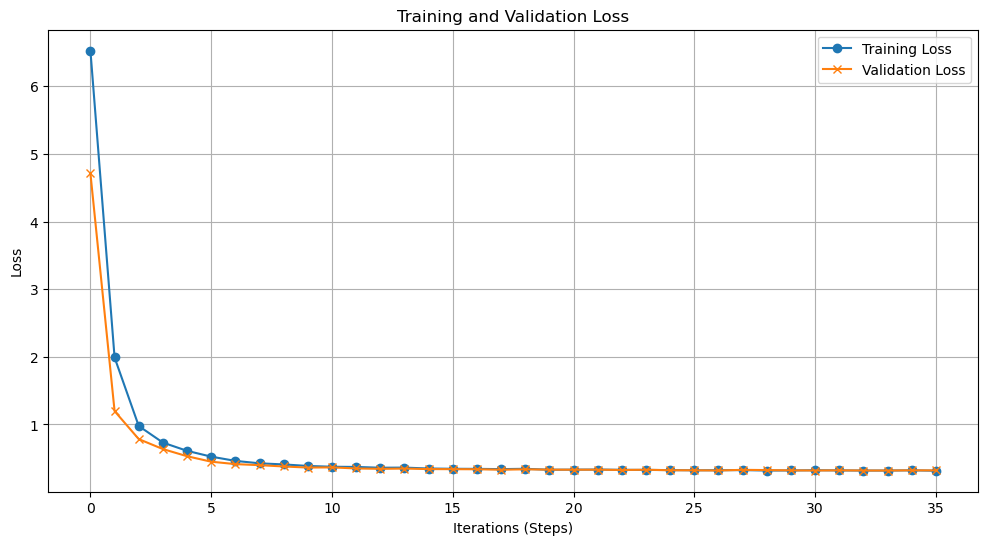

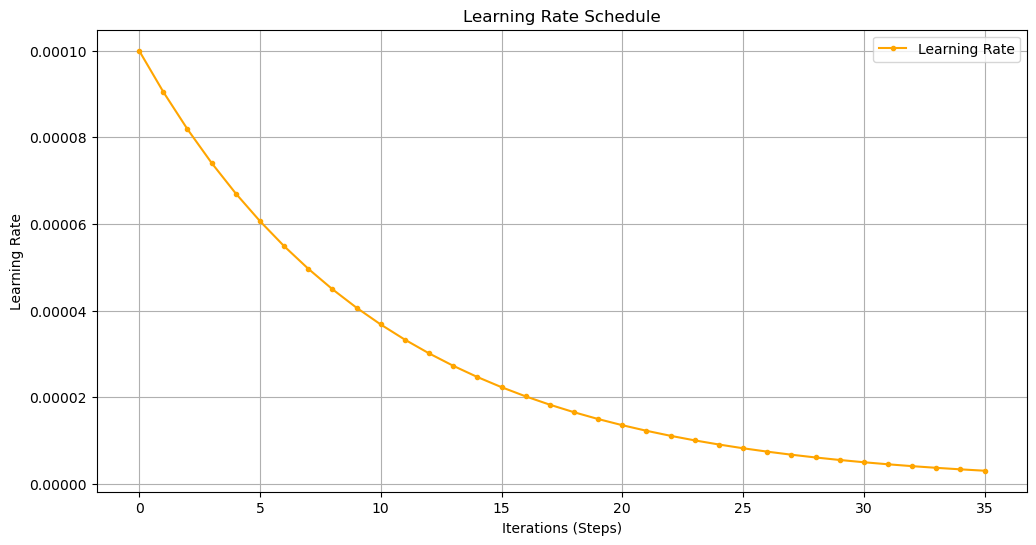

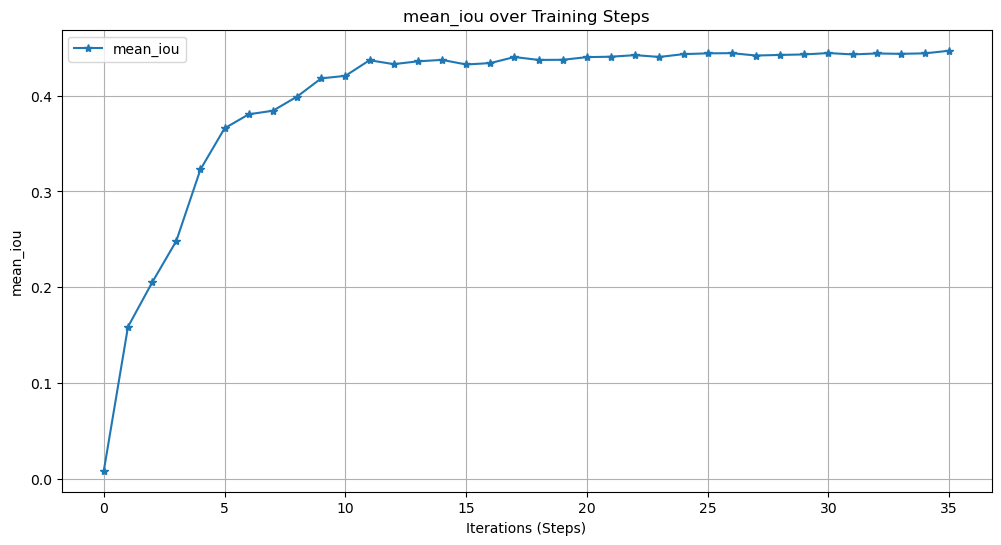

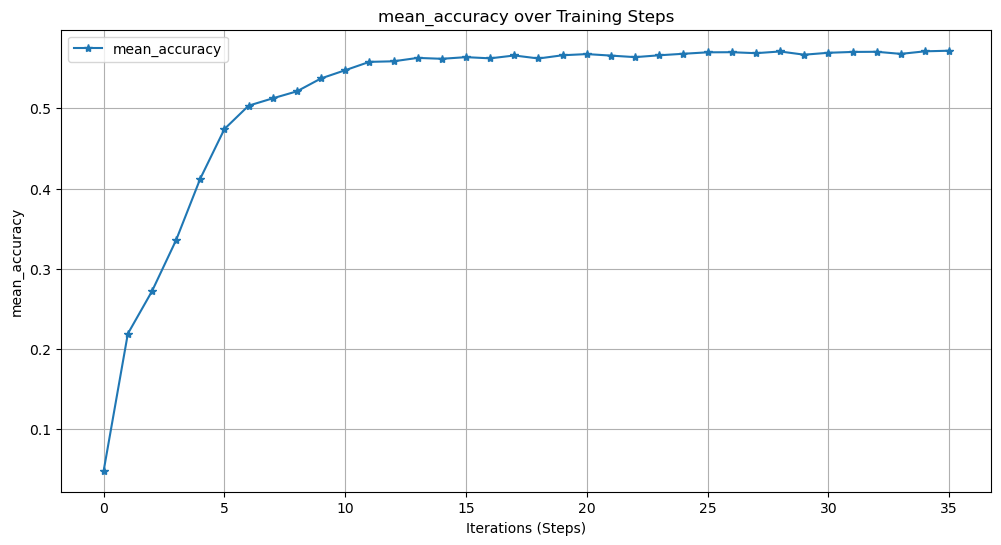

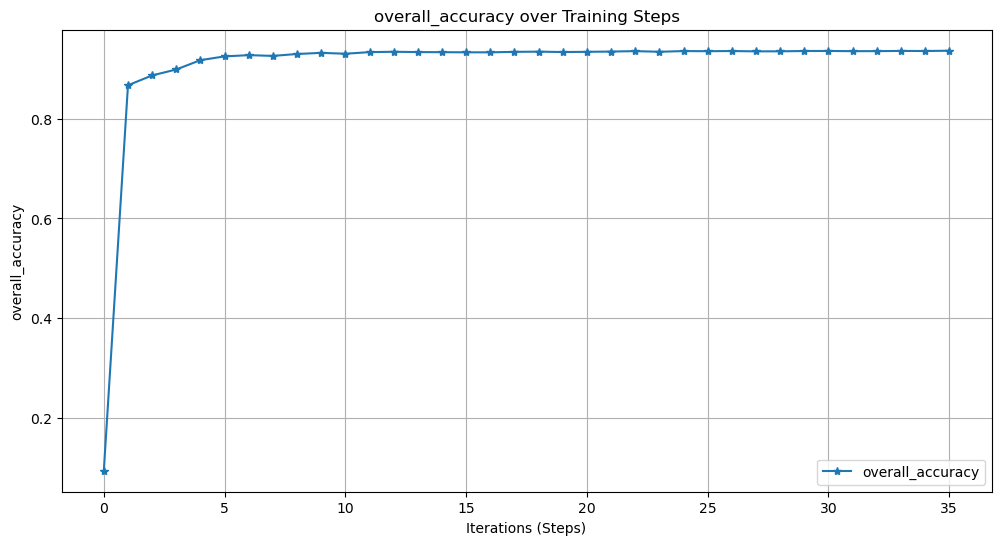

In [20]:
import matplotlib.pyplot as plt

epochs = list(range(len(log_list)))
training_losses = [log["training_loss"] for log in log_list]
val_losses = [log["val_loss"] for log in log_list]
learning_rates = [log["LR"] for log in log_list]

metric_names = [key for key in log_list[0] if key not in ["training_loss", "val_loss", "LR"]]
metrics = {name: [log[name] for log in log_list] for name in metric_names}

plt.figure(figsize=(12, 6))
plt.plot(epochs, training_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="x")
plt.xlabel("Iterations (Steps)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, learning_rates, label="Learning Rate", color="orange", marker=".")
plt.xlabel("Iterations (Steps)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

for name, values in metrics.items():
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, values, label=name, marker="*")
    plt.xlabel("Iterations (Steps)")
    plt.ylabel(name)
    plt.title(f"{name} over Training Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The performance of the original model before fine tuning.

In [1]:
from transformers import AutoFeatureExtractor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation
from PIL import Image
import requests

# apple model performance
model_name = "apple/deeplabv3-mobilevit-small"
original_processor = MobileViTFeatureExtractor.from_pretrained(model_name)
original_processor.do_center_crop = False
original_model = MobileViTForSemanticSegmentation.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# load the image
# url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("3.png")

# pre-process the image
inputs = original_processor(images=image, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = original_model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg_original = upsampled_logits.argmax(dim=1)[0].cpu()

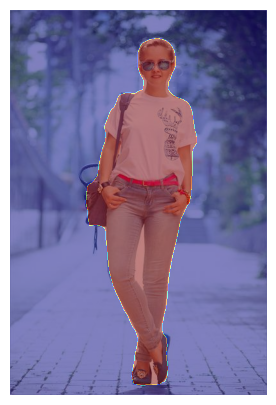

In [4]:
# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg_original, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

Model after fine tuning.

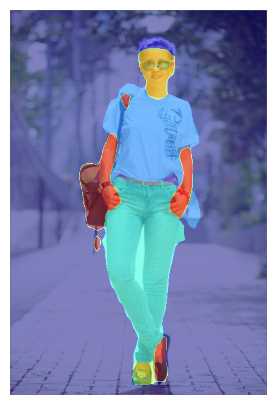

In [5]:
# load the model from fine tuning
model_dir = "./7"

model = MobileViTForSemanticSegmentation.from_pretrained(model_dir).to("cuda" if torch.cuda.is_available() else "cpu")

# apply the model
outputs = model(**inputs)
logits = outputs.logits

# up sample the mask to the original size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# get the segmentation result
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu()

# overlay the mask result on the image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.imshow(pred_seg, cmap="jet", alpha=0.5)  # transparent mask
ax.axis("off")
plt.show()

# Applying the Lut to the image

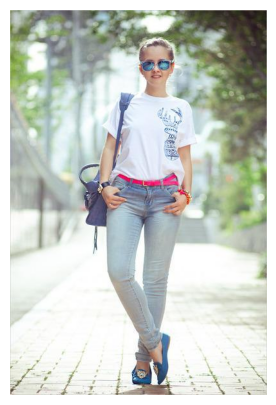

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image)
ax.axis("off")
plt.show()

In [ ]:
pip install pillow pillow-lut

  Preparing metadata (setup.py) ... done
  Created wheel for pillow-lut: filename=pillow_lut-1.0.1-py3-none-any.whl size=10473 sha256=e3a572be4feb9011ef30f0e3639b9489d199ec4203c65a20068eee8611796f5b
  Stored in directory: /root/.cache/pip/wheels/c1/c9/b0/e80cbc8b67d6d193d9932946a0570a363175a192df879a8436
Successfully built pillow-lut


In [10]:
from PIL import Image
from pillow_lut import load_cube_file

lut = load_cube_file("./Duotone.cube")
im = Image.open("3.png")
im.filter(lut).save("image-with-lut-applied.png")

Start to apply filter to part of the image.

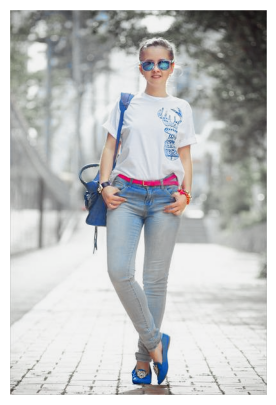

In [11]:
from PIL import Image
import numpy as np

# load the image
# im = Image.open("1.jpeg")
im = image
im_lut = Image.open("image-with-lut-applied.png")
# mask = Image.open("mask.png")
mask = pred_seg

# change to NumPy array
mask_array = np.array(mask)
im_array = np.array(im)
im_lut_array = np.array(im_lut)

# categories for skin
categories_to_keep = [11, 12, 13, 14, 15]

# mask for skin
keep_mask = np.isin(mask_array, categories_to_keep)

final_image_array = np.where(keep_mask[..., None], im_array, im_lut_array)

# save and plot the image
final_image = Image.fromarray(final_image_array.astype('uint8'))
final_image.save("final_image2.png")
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(final_image)
ax.axis("off")
plt.show()

summarize how many pixel points in each class in the mask image.

In [ ]:
# pred_seg

unique_values, counts = torch.unique(pred_seg, return_counts=True)

# make a table
table = {int(value.item()): count.item() for value, count in zip(unique_values, counts)}

# print result
print("Value - Count")
for value, count in table.items():
    print(f"{value} - {count}")

Value - Count
0 - 1158071
1 - 90
2 - 6207
4 - 210231
6 - 94859
11 - 23773
14 - 21
15 - 2127
16 - 4621


### Reference

These codes were modified based on this project: [Segformer B2 fine-tuned for clothes segmentation](https://huggingface.co/mattmdjaga/segformer_b2_clothes).